***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [2. Mathmatical Groundwork](2_0_introduction.ipynb)  
    * Previous: [2.10 Linear Algrebra](2_10_linear_algebra.ipynb)
    * Next: [2.12 Solid Angle](2_12_solid_angle.ipynb)

***

Import standard modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

Import section specific modules:

In [2]:
from scipy.optimize import leastsq
plt.rcParams['figure.figsize'] = (18, 6)

In [3]:
from IPython.display import HTML
HTML('../style/code_toggle.html')

## 2.11 Least-squares Minimization<a id='groundwork:sec:leastsquares'></a>

In the field of radio interferometry, we often encounter problems which must be solved numerically. One such problem is least-squares minimization. Conceptually, it is very simple. Given a model and some data, we want to find the values of a set of parameters which minimize the difference between our model and our observations. 

Firstly, we need to phrase the problem in simple mathematics. Let us start by defining the quantities of interest and the function we wish to minimize. 

We will refer to our data vector as $\mathbf{d}$ and our model vector as $\mathbf{m}$. These vectors contain the measured values and those predicted by the model respectively. We wish to minimize the $L^2$ or Euclidean vector norm of their difference. Whilst you may not have called it that in the past, you have almost certainly encountered it,

$$\lVert\mathbf{r}\rVert = \lVert\mathbf{d}-\mathbf{m}\rVert = \sqrt{\sum\limits_{i=1}^N(d_i - m_i)^2}.$$

$\mathbf{r}$ is the residual vector and it is a measure of the difference between the values predicted by our model and the observed values.

It is important to note that in general $\mathbf{m}$ is a function of a number of parameters, such as $(x_1, x_2, x_3, \dots)$. These parameters form the parameter vector $\mathbf{x}$ which is what we ultimately want to determine.

There are many methods which solve problems of the given form. However, we will stick to explaining two of the most commonly used in radio interferometry. Specifically, these are Gauss-Newton and Levenberg–Marquardt; both of which are technically non-linear least squares solvers. They can be applied to linear problems too.

We will not present the derivations of the methods, although they are readily available. The Gauss-Newton update rule is given by the following:

$$\delta \mathbf{x} = {(\mathbb{J}^T\mathbb{J})}^{-1} \mathbb{J}^T \mathbf{r}.$$

This is far simpler than it may at first appear. $\delta \mathbf{x}$ is simply the update to the current best guess of the parameter vector. $\mathbb{J}$ is the Jacobian of the problem which we will discuss in detail shortly. $(\cdot)^T$ denotes a matrix transpose, and $(\cdot)^{-1}$ denotes a matrix inverse. $\mathbf{r}$ is still the residual vector. In practice we use an iterative algorithm which starts from some initial guess which is updated in accordance with:

$$x_{k+1} = x_{k} + \delta x$$

The Jacobian is simply a matrix of the first derivatives of the model term relative to the parameter vector. This can be writen analytically for a model vector of length $M$ and a parameter vector of length $N$ as:

$$\mathbb{J} = \frac{\delta \mathbf{m}}{\delta \mathbf{x}} = \begin{bmatrix}
    \frac{\delta m_1}{\delta x_1} & \frac{\delta m_1}{\delta x_2} & \dots  & \frac{\delta m_1}{\delta x_N} \\
    \frac{\delta m_2}{\delta x_1} & \frac{\delta m_2}{\delta x_2} & \dots  & \frac{\delta m_2}{\delta x_N} \\
    \vdots & \vdots & \ddots & \vdots \\
    \frac{\delta m_M}{\delta x_1} & \frac{\delta m_M}{\delta x_2} & \dots  & \frac{\delta m_M}{\delta x_N}
\end{bmatrix}$$ 

This convention is somewhat unique to the radio interferometry problem. The Jacobian is usually defined as the derivative of the residual vector relative to the parameter vector. This has an associated change of sign, though it doesn't alter the algorithm. For the sake of consistency, we will stick to the positive, interferometric convention. 

For the sake of completeness, we will also introduce the Levenberg-Marquardt update rule. It is used more frequently as it has better convergence behaviour than basic Gauss-Newton. The update rule itself is very similar:

$$\delta \mathbf{x} = {(\mathbb{J}^T\mathbb{J}+\lambda_{LM} \mathbf{D})}^{-1} \mathbb{J}^T \mathbf{r}.$$

The addition of the $\lambda_{LM} \mathbf{D}$ factor leads to the Levenberg-Marquardt algorithm being referred to as a damped least squares method. There is a degree of choice regarding the matrix $\mathbf{D}$. However, in practice it is usually the identity matrix, $\mathbf{I}$, or a matrix containing the diagonal entries of $\mathbb{J}^T\mathbb{J}$. The lambda factor is used to tune the algorithm and improve its convergence. The choice of lambda is largely heurstic, and a value which works in one case may fail completely in another. This highlights an important fact regarding least squares methods: the choice of starting parameters does alter the behaviour of the algorithm. This will become clearer as we proceed.

It is useful to note that, when we implement these methods, it is worth implementing Levenberg-Marquardt as setting $\lambda$ to zero will always return us to the Gauss-Newton approach. 

Armed with the mathematical background above, we can now begin to implement a rudimentay Levenberg-Marquardt solver. We will start with a relatively simple function and demonstrate how we set up the algorithm. The function which we will use is as follows:

$$ m_i = x_1 \sin(2\pi x_2 t_i + x_3).$$

This is the equation for a simple sinusoid. The parameters $x_1$, $x_2$ and $x_3$ have been used in place of the more traditional $A$, $\nu$ and $\phi$ in order to maintain a consistent notation.

As we will not be performing a true experiment, we will obtain our "measured" values by adding some gaussian noise to our model signal. 

Before we begin implementing the solver, we will write out the derivatives of the model function. These will be used to construct the Jacobian. The derivatives are as follows:

$$ \frac{\delta m_i}{\delta x_1} = \sin(2\pi x_2 t_i + x_3)$$

$$ \frac{\delta m_i}{\delta x_2} = 2 \pi t_i x_1 \cos(2\pi x_2 t_i + x_3)$$

$$ \frac{\delta m_i}{\delta x_3} = x_1 \cos(2\pi x_2 t_i + x_3).$$

These derivatives are very easy to calculate analytically. Note that $t$ is the independent variable for the problem and its index, $i$, simply enumerates the number of samples we have, which is in turn simply the length of our residual vector. 

In [4]:
def sinusoid(x, t):
    """
    Returns a vector containing the values of a sinusoid with parameters x evaluated at points t.
    
    INPUTS:
    t    Value of independent variable at the sampled points.
    x    Vector of parameters.    
    """
    
    x1 = x[0]     #Amplitude
    x2 = x[1]     #Frequency
    x3 = x[2]     #Phase-shift
    
    return x1*np.sin(2*np.pi*x2*t + x3)

In [5]:
def sinusoid_jacobian(x, t):
    """
    Returns the Jacobian corresponding to the function defined in sinusoid.
    
    INPUTS:
    t    Value of independent variable at the sampled points.
    x    Vector of parameters.    
    """
    
    x1 = x[0]     #Amplitude
    x2 = x[1]     #Frequency
    x3 = x[2]     #Phase-shift
    
    jacobian = np.empty([t.shape[0], x.shape[0]])
    jacobian[:,0] = np.sin(2*np.pi*x2*t + x3)
    jacobian[:,1] = 2*np.pi*t*x1*np.cos(2*np.pi*x2*t + x3)
    jacobian[:,2] = x1*np.cos(2*np.pi*x2*t + x3)
    
    return jacobian    

In [6]:
def sinusoid_residual(x, t, d):
    """
    Returns a vector containing the residual values.
    
    INPUTS:
    d    Vector of measured values.
    t    Value of independent variable at the sampled points.
    x    Vector of parameters.    
    """
    
    return d - sinusoid(x, t)

The three functions defined above will be used frequently during the Levenberg-Marquardt solution procedure. The following few lines of code just set up the values we need to call the Levenberg-Marquardt solver.

In [7]:
t = np.arange(-0.06, 0.06, 0.06/300)          #The points at which we will be taking our "measurements"
noise = 2*np.random.normal(size=(t.shape[0])) #A noise vector which we will use to manufacture "real" measurements.
true_x = np.array([10., 33.3, 0.52])          #The true values of our parameter vector.
x = np.array([8., 43.5, 1.05])                #Initial guess of parameter vector for our solver.

In [8]:
d = sinusoid(true_x, t) + noise #Our "observed" data, contructed from our true parameter values and the noise vector.
m = sinusoid(x, t)              #Our fitted function using the initial guess parameters.

The following plots show the observed data and the curve corresponding to our initial guess for the parameters.

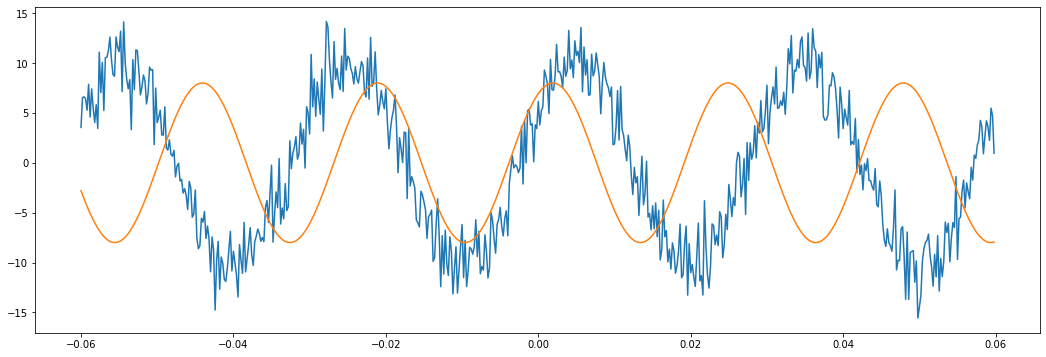

In [9]:
plt.plot(t, d)
plt.plot(t, m)
plt.show()

In [10]:
def levenberg_marquardt(d, t, x, r_func, j_func, maxit=100, lamda=1, K=10, eps1=1e-6, eps2=1e-6):
    """
    Returns a vector containing the optimal parameter values found by the algorithm.
    
    INPUTS:
    d         Vector of measured values.
    t         Value of independent variable at the sampled points.
    x         Vector of parameters.
    r_func    Function which generates the residual vector.
    j_func    Function which generates the Jacobian.
    maxiter   Maximum number of iterations.
    lamda     Initial value of tuning parameter.
    K         Initial value of retuning factor.
    eps1      First tolerance parameter - triggers when residual is below this number.
    eps2      Second tolerance parameter - triggers when relative changes to the parameter
              vector are below this number.
    """
    
    #Initialises some important values and stores the original lamda value.
    
    r = r_func(x, t, d)
    old_chi = np.linalg.norm(r)
    olamda = lamda
    it = 0
    
    while True:
        
        #Heavy lifting portion of the algorithm. Computes the parameter update.
        #This is just the implementation of the mathmatical update rule.
        
        J = j_func(x, t)
        JT = J.T
        JTJ = JT.dot(J)
        JTJdiag = np.eye(JTJ.shape[0])*JTJ
        JTJinv = np.linalg.pinv(JTJ + lamda*JTJdiag)
        JTr = JT.dot(r)
        
        delta_x = JTJinv.dot(JTr)
        x += delta_x
        
        #Convergence tests. If a solution has been found, returns the result.
        #The chi value is the norm of the residual and is used to determine
        #whether the solution is improving. If the chi value is sufficiently 
        #small, the function terminates. The second test checks to see whether
        #or not the solution is improving, and terminates if it isn't.
        
        r = r_func(x, t, d)
        new_chi = np.linalg.norm(r)
        
        if new_chi < eps1:
            return x
        elif np.linalg.norm(delta_x) < eps2*(np.linalg.norm(x) + eps2):
            return x
        
        #Tuning stage. If the parameter update was good, continue and restore lamda.
        #If the update was bad, scale lamda by K and revert last update.
        
        if new_chi > old_chi:
            x -= delta_x
            lamda = lamda*K
        else:
            old_chi = new_chi
            lamda = olamda
            
        #If the number of iterations grows too large, return the last value of x.
        
        it += 1
            
        if it >= maxit:
            return x

The above is the main function of the Levenberg-Marquardt algorithm. The code may appear daunting at first, but all it does is implement the Levenberg-Marquardt update rule and some checks of convergence. We can now apply it to the problem with relative ease to obtain a numerical solution for our parameter vector.

In [11]:
solved_x = levenberg_marquardt(d, t, x, sinusoid_residual, sinusoid_jacobian)
print(solved_x)

[10.20832747 33.36688045  0.519639  ]


We can now compare our numerical result with both the truth and the data. The following plot shows the various quantities of interest.

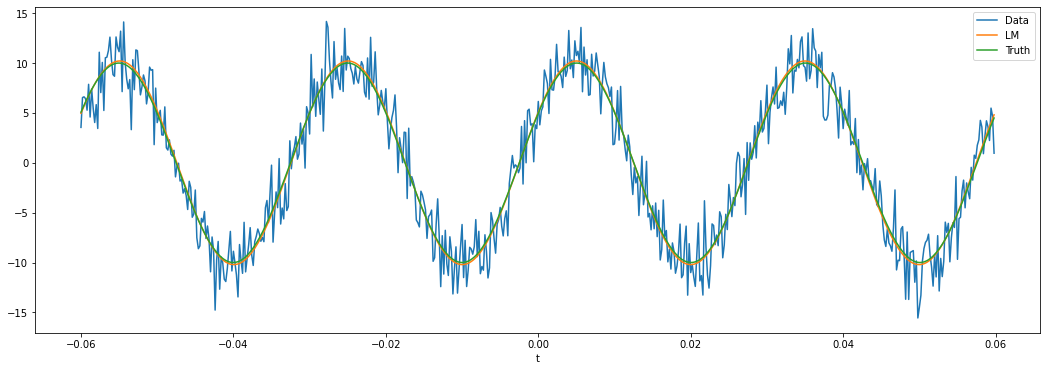

In [12]:
plt.plot(t, d, label="Data")
plt.plot(t, sinusoid(solved_x, t), label="LM")
plt.plot(t, sinusoid(true_x, t), label="Truth")
plt.xlabel("t")
plt.legend(loc='upper right')
plt.show()

The fitted values are so close to the true values that it is almost impossible to differentiate between the red and green lines in the above plot. The true values have been omitted from the following plot to make it clearer that the numerical solution does an excellent job of arriving at the correct parameter values.

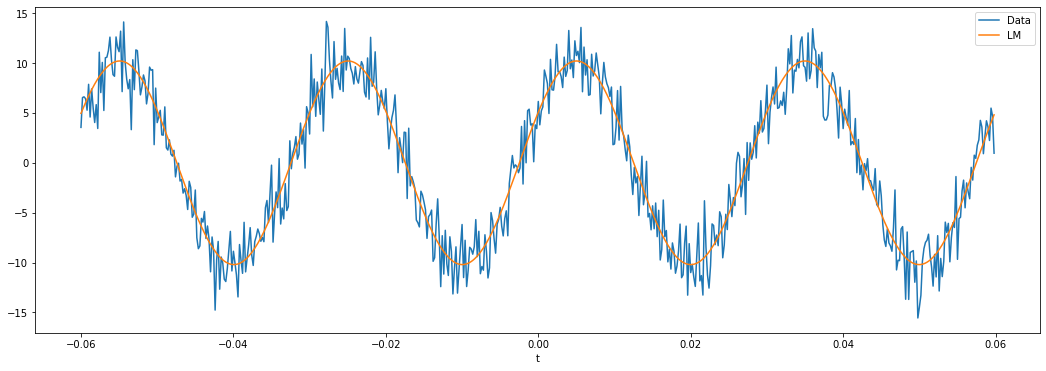

In [13]:
plt.plot(t, d, label="Data")
plt.plot(t, sinusoid(solved_x, t), label="LM")
plt.xlabel("t")
plt.legend(loc='upper right')
plt.show()

A final, important thing to note is that the Levenberg-Marquardt algorithm is already implemented in Python. It is used in scipy.optimise.leastsq. This is often useful for doing rapid numerical solution without the need for an analytic Jacobian. As a simple proof, we can call the built-in method to verify our results.

scipy.optimize.leastsq:  [ 1.38539391 53.67084102  0.6515123 ]
Our LM:  [10.20832747 33.36688045  0.519639  ]


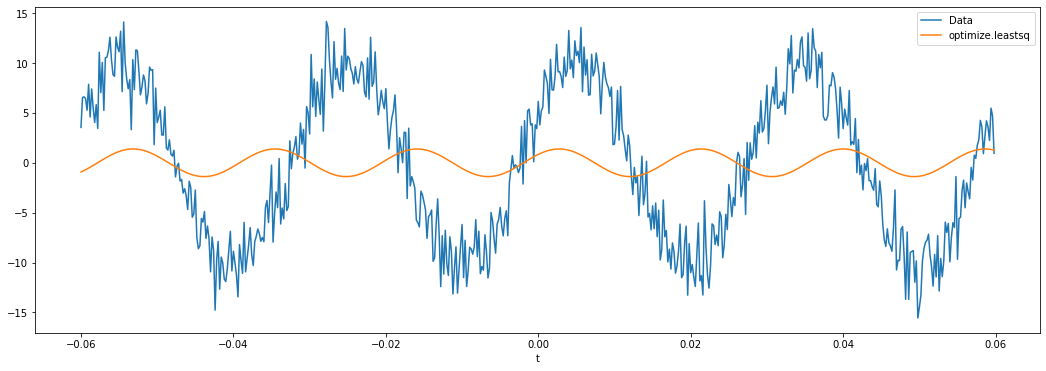

In [14]:
x = np.array([8., 43.5, 1.05]) 

leastsq_x = leastsq(sinusoid_residual, x, args=(t, d)) 

print("scipy.optimize.leastsq: ", leastsq_x[0])
print("Our LM: ", solved_x)

plt.plot(t, d, label="Data")
plt.plot(t, sinusoid(leastsq_x[0], t), label="optimize.leastsq")
plt.xlabel("t")
plt.legend(loc='upper right')
plt.show()

In this case, the built-in method clearly fails. I have done this deliberately to illustrate a point - a given implementation of an algorithm might not be the best one for your application. In this case, the manner in which the tuning parameters are handled prevents the solution from converging correctly. This can be avoided by choosing a starting guess closer to the truth and once again highlights the importance of initial values in problems of this type.

scipy.optimize.leastsq:  [10.20834912 33.36688156  0.51963909]
Our LM:  [10.20832747 33.36688045  0.519639  ]


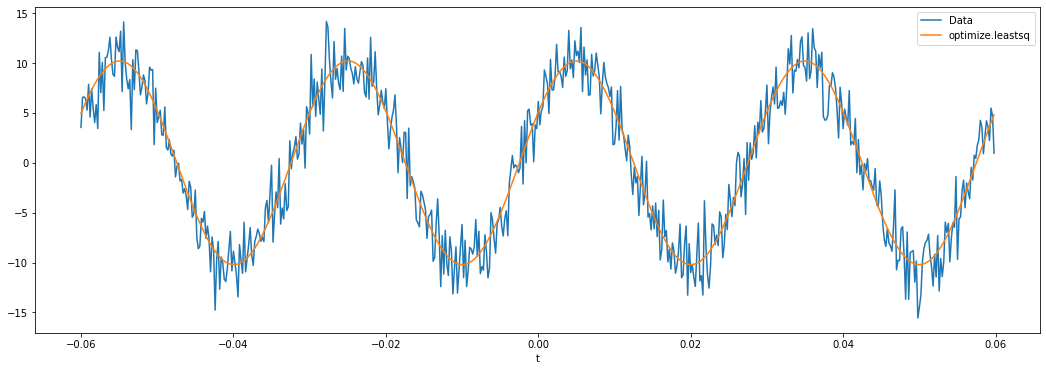

In [15]:
x = np.array([8., 35., 1.05]) 

leastsq_x = leastsq(sinusoid_residual, x, args=(t, d)) 

print("scipy.optimize.leastsq: ", leastsq_x[0])
print("Our LM: ", solved_x)

plt.plot(t, d, label="Data")
plt.plot(t, sinusoid(leastsq_x[0], t), label="optimize.leastsq")
plt.xlabel("t")
plt.legend(loc='upper right')
plt.show()

With a better initial estimate, the built-in method converges without issue and its results strongly agree with those of our implementation.

***
* Next: [2.12 Solid Angle](2_12_solid_angle.ipynb)